# This ArcGIS Notebook publishes [Airbus OneAtlas Data](https://oneatlas.airbus.com/) satellite archive, and tasking orders directly to ArcGIS Image for ArcGIS Online

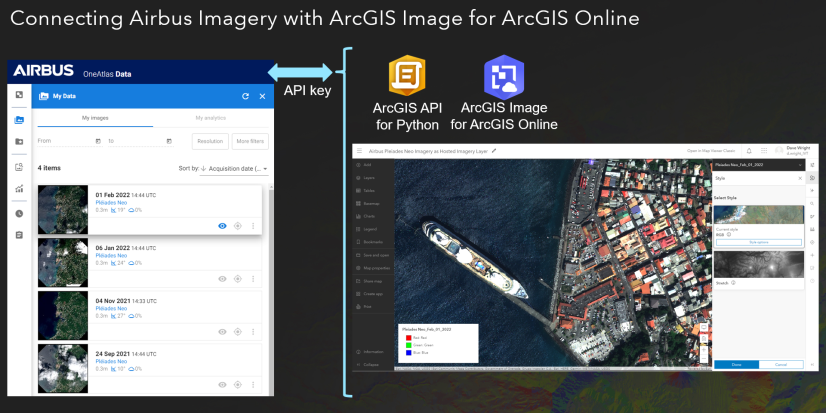

## Instead of using local internet connection to download, and then upload...

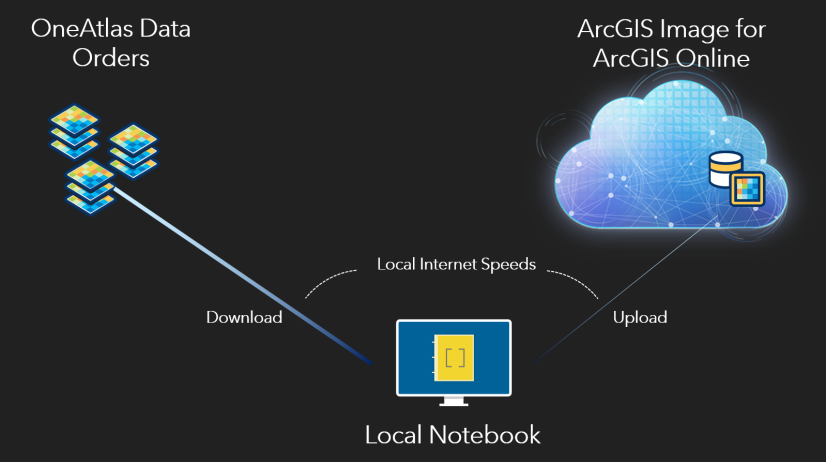

## ...we can host the notebook in ArcGIS Online, and download the imagery directly into ArcGIS Online using cloud network communications  

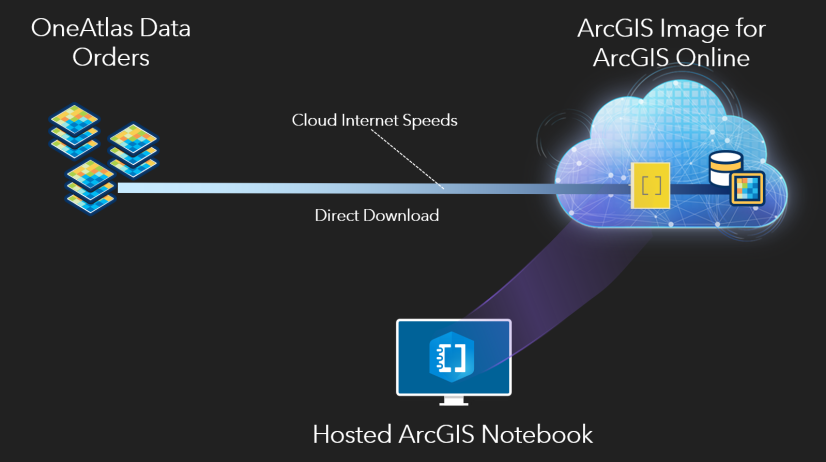

## First, we need to install a package to support file transfer, and then import some packages that support the publishing workflow:

In [ ]:
!pip install azure-storage-blob

import datetime
import glob
from json import dumps, loads
from os import path, listdir, mkdir
from zipfile import ZipFile
import requests
from getpass import getpass
import arcgis
from arcgis.geometry import Geometry
arcgis.env.verbose = True # set this for detailed output during publishing 
print(arcgis.__version__)

## Next we setup some functions to interact with the OneAtlas Data API using an Airbus API Key:

In [ ]:
api_key = getpass("Enter your OneAtlas Data API key: ")

def get_token(user_api_key):
    url = 'https://authenticate.foundation.api.oneatlas.airbus.com/auth/realms/IDP/protocol/openid-connect/token'
    payload='client_id=IDP&grant_type=api_key&apikey=' + user_api_key
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    response = requests.request('POST', url, headers=headers, data=payload)
    return loads(response.text)['access_token']

def get_workspace_id(auth_header):
    url = 'https://data.api.oneatlas.airbus.com/api/v1/me'
    payload = {}
    headers = {'Authorization': auth_header}
    my_info = requests.request('GET', url, headers=headers, data=payload)
    return loads(my_info.text)['contract']['workspaceId']

def download_data(url, save_directory, extension, save_file=""):
    headers = {
        "Cache-Control": "no-cache",
        "Authorization": auth_header, 
        "Content-Type": "application/json"
    }
    
    if save_file == "":
        save_file = f"{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}{extension}"

    try:
        save_path = path.join(save_directory, save_file)
        with requests.get(url=url, headers=headers, stream=True) as r:
            r.raise_for_status()
            with open(save_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):  
                    f.write(chunk)
    except Exception as e:
        print(f"Download failed: {e}")
        return None
        
    print(f"Download completed")
    return save_path

token = get_token(user_api_key=api_key)
auth_header = f"Bearer {token}"
workspace_id = get_workspace_id(auth_header)

## Next is to specify directories in your ArcGIS Online home storage to be used for the imagery downloads, and archive decompression. Note: this needs be something in your /arcgis/home/ directory

In [5]:
save_directory = "/arcgis/home/Airbus_OneAtlas_Data_downloads"

if not path.isdir(save_directory):
    mkdir(save_directory)

unzipped_data_directory = "/arcgis/home/unzipped_data"

if not path.isdir(unzipped_data_directory):
    mkdir(unzipped_data_directory)

## Now we can search the ‘MyData’ workspace in OneAtlas Data API for delivered products. Note the querystring dictionary, and the convention for timedate range selection. In this case, we’re searching for any imagery orders with an acquisition datetime within the GMT hours of February 1, 2022. The JSON response is organized into three Python lists.

In [11]:
# This ensures the layer's base name will be unique by integrating a timestamp
timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')

url = "https://search.foundation.api.oneatlas.airbus.com/api/v2/opensearch"

querystring = {"acquisitionDate": "[2022-02-01T00:00:00.000Z,2022-02-01T23:59:59.999Z]", 
               "itemsPerPage":100, 
               "startPage":1, 
               "sortBy": "-publicationDate", 
               "workspace": workspace_id, 
               "platform": "PNEO3"}
headers = {
    'Cache-Control': 'no-cache',
    'Authorization': auth_header, 
    'Content-Type': 'application/json'}

resp = requests.request('GET', url, headers=headers, params=querystring)

image_download_links = []
image_geometries = []
image_thumbnails = []

for feature in resp.json()["features"]:
    image_geometries.append(feature["geometry"])
    image_thumbnails.append(feature["_links"]["thumbnail"]["href"])
    if "download" in feature["_links"]:
        image_download_links.append(feature["_links"]["download"][2]["href"])
    else:
        image_download_links.append("")

## Now we can preview the product quicklook, and footprint geometry before publishing:

Download completed
/arcgis/home/Airbus_OneAtlas_Data_downloads/20240514220648.jpg


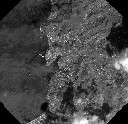

In [12]:
from IPython.display import Image

thumbnail_path = download_data(url=image_thumbnails[0],
                               save_directory=save_directory,
                               extension=".jpg")
print(thumbnail_path)
Image(filename = thumbnail_path)

In [ ]:
from arcgis.gis import GIS
gis = GIS("home")

geometry_json = {
    "rings": image_geometries[0]["coordinates"],
    "spatialReference": {
    "wkid": 4326
  }
}

geometry_obj = Geometry(geometry_json)

m1 = gis.map()
m1.draw(geometry_obj)
m1.extent = dict(geometry_obj.envelope)
m1

## OK, this is what we want to publish. let’s download the product ZIP archive to the ArcGIS Online home storage:

In [ ]:
zip_files = []

for image_download_link in image_download_links:
    zip_path = download_data(url=image_download_link,
                             save_directory=save_directory,
                             extension=".zip")
    zip_files.append(zip_path)
    
zip_files

## Decompress ZIP archive, and identify all the image files:

In [17]:
for zip_file in zip_files:
    z = ZipFile(path.join(save_directory, zip_file))
    z.extractall(path=unzipped_data_directory)

## Using the 'Files' button in the toolbar, we can now navigate to the download, or decompressed data folder to browse files in the ArcGIS Online home storage

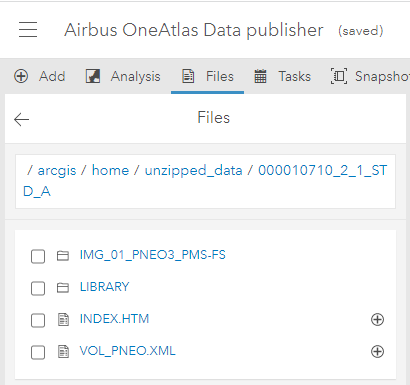

## Publish as Tiled Imagery Layer:

In [ ]:
# Multiple products in the product_list should be of common product processing options from Airbus.
product_list = ['/arcgis/home/unzipped_data/000017885_3_1_STD_A']

from arcgis.raster.analytics import copy_raster

layer_name="Pleiades_Neo_tiled_" + timestamp
copy_raster_op = copy_raster(input_raster=product_list, 
                             output_name=layer_name, 
                             raster_type_name="Pleiades NEO",
                             raster_type_params={"productType": "ORTHO REFLECTANCE",
                                                 "processingTemplate": "Multispectral Reflectance"},
                             tiles_only=True)

## Load a map to view an interactive map of the published Airbus Imagery layer:

In [ ]:
pleiades_neo_layer = gis.content.search(layer_name)[0].layers[0]
from arcgis.raster.functions import stretch

stretched_op = stretch(pleiades_neo_layer,stretch_type=3,dra=True,min_percent=0.5,max_percent=0.5,gamma=[1.4,1.4,1.4])
m2 = gis.map()
m2.add_layer(stretched_op)
m2.legend = True
m2.zoom_to_layer(stretched_op)
m2

## Note: Now that the layer is published, be sure and delete the compressed, and decompressed files from ArcGIS Online home storage!

In [ ]:
!rm -R /arcgis/home/Airbus_OneAtlas_Data_downloads/
!rm -R /arcgis/home/unzipped_data/

## Now we can import raster functions, and synchronize map extent changes dynamically for any band combinations needed:

In [ ]:
neoScene020122 = gis.content.get("2f703217b1124f7c9e372b6fbb5fed3d").layers[0] # be sure and substitute your own variable name, and associated itemID 
neoScene010622 = gis.content.get("1bb7b69851224e8d8b2b98456dee6b64").layers[0] # be sure and substitute your own variable name, and associated itemID
neoScene110421 = gis.content.get("35117baa30c4412f8774e1ea03fe4765").layers[0] # be sure and substitute your own variable name, and associated itemID
neoScene092421 = gis.content.get("64718ac0edaf44829696c0abeb27f7c1").layers[0] # be sure and substitute your own variable name, and associated itemID

from ipywidgets import *
from  arcgis.raster.functions import extract_band

def side_by_side(band_nums_for_composite, frame_titles):

    satmap1 = gis.map(location="St. George's, GRD", zoomlevel=13, mode='2d')
    neoScene020122_comp = extract_band(neoScene020122, band_ids = band_nums_for_composite)
    satmap1.add_layer(neoScene020122_comp)
    satmap2 = gis.map(location="St. George's, GRD", zoomlevel=13, mode='2d')
    neoScene010622_comp = extract_band(neoScene010622, band_ids = band_nums_for_composite)
    satmap2.add_layer(neoScene010622_comp) 
    satmap3 = gis.map(location="St. George's, GRD", zoomlevel=13, mode='2d')
    neoScene110421_comp = extract_band(neoScene110421, band_ids = band_nums_for_composite)
    satmap3.add_layer(neoScene110421_comp)
    satmap4 = gis.map(location="St. George's, GRD", zoomlevel=13, mode='2d')
    neoScene092421_comp = extract_band(neoScene092421, band_ids = band_nums_for_composite)
    satmap4.add_layer(neoScene092421_comp)
    
    satmap1.layout=Layout(flex='1 1', padding='6px', height='450px')
    satmap2.layout=Layout(flex='1 1', padding='6px', height='450px')
    satmap3.layout=Layout(flex='1 1', padding='6px', height='450px')
    satmap4.layout=Layout(flex='1 1', padding='6px', height='450px')
    satmap1.sync_navigation(satmap2)
    satmap2.sync_navigation(satmap2)
    satmap3.sync_navigation(satmap2)
    satmap4.sync_navigation(satmap2)
    box1 = HBox([satmap1, satmap2, satmap3, satmap4])

    box_layout = Layout(flex='1 1',width='1500px', padding='6px', height='30px')
    words = frame_titles
    items = [Button(description=word, layout=box_layout) for word in words]
    box2 = HBox(items)
    box3 = VBox([box2, box1])
    return box3

In [ ]:
pleiades_neo_layer = gis.content.search(layer_name)[0].layers[0]

from ipywidgets import *
from  arcgis.raster.functions import extract_band

def side_by_side(band_nums_for_composite, frame_titles):

    satmap1 = gis.map(location="St. George's, GRD", zoomlevel=13, mode='2d')
    neoScene020122_comp = extract_band(pleiades_neo_layer, band_ids = band_nums_for_composite)
    satmap1.add_layer(neoScene020122_comp)    
    satmap1.layout=Layout(flex='1 1', padding='6px', height='450px')


    box1 = HBox([satmap1])

    box_layout = Layout(flex='1 1',width='1500px', padding='6px', height='30px')
    words = frame_titles
    items = [Button(description=word, layout=box_layout) for word in words]
    box2 = HBox(items)
    box3 = VBox([box2, box1])
    return box3

## These examples show how to call the function dynamically for a variety of band combinations:

### RGB composite (natural color):

In [ ]:
side_by_side([1,2,3], ['Date: Sep-24-2021 RGB', 'Date: Nov-04-2021 RGB', 'Date: Jan-06-2022 RGB', 'Date: Feb-01-2022 RGB'])

### Deep blue composite:

In [ ]:
side_by_side([1,2,6], ['Date: Sep-24-2021 RGDeepblue', 'Date: Nov-04-2021 RGDeepblue', 'Date: Jan-06-2022 RGDeepblue', 'Date: Feb-01-2022 RGDeepblue'])

### Color Infrared (CIR):

In [ ]:
side_by_side([4,1,3], ['Date: Sep-24-2021 CIR', 'Date: Nov-04-2021 CIR', 'Date: Jan-06-2022 CIR', 'Date: Feb-01-2022 CIR'])

### Color Infrared substituting red edge for near-infrared:

In [ ]:
side_by_side([5,1,3], ['Date: Sep-24-2021 CIR with Rededge', 'Date: Nov-04-2021 CIR with Rededge', 'Date: Jan-06-2022 CIR with Rededge', 'Date: Feb-01-2022 CIR with Rededge'])